# Minimal plenoptic working example

This notebook shows the minimum steps we want to be able to recreate with the external models. We will:
- initialize an image and a model
- run metamer synthesis until convergence
- make a plot and video of the synthesis procedure.

See [plenoptic docs](https://docs.plenoptic.org/) for more details.

In [46]:
import plenoptic as po
import torch
# needed for the plotting/animating:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['animation.html'] = 'html5'
# use single-threaded ffmpeg for animation writer
plt.rcParams['animation.writer'] = 'ffmpeg'
plt.rcParams['animation.ffmpeg_args'] = ['-threads', '1']

In plenoptic, we represent stimuli as 4d tensors, with shape `(batch, channel, height, width)`. Plenoptic contains some built-in images, all of which can be found in the `po.data.` module: `einstein`, `curie`, `color_wheel`, `parrot`, `reptile_skin`. 

Currently, only `color_wheel` is a color image. By default, the other (grayscale) images will be loaded in with a single channel. You can make them "RGB" images by passing `as_gray=False` to their respective functions or calling `img.repeat(1,3,1,1)`

torch.Size([1, 1, 256, 256])


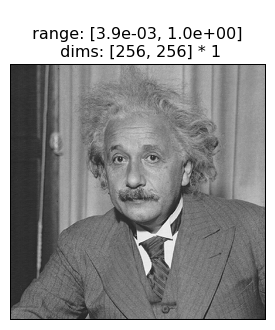

In [47]:
img = po.data.einstein().to(0)
print(img.shape)
po.imshow(img);

Plenoptic model requirements (see [docs](https://docs.plenoptic.org/docs/branch/main/models.html) for more details):
- They must have a call method (equivalently, be a `torch.nn.Module` and have a `forward` method).
- This method must accept a 4d tensor and return a 3d or 4d tensor.
- They must be differentiable by torch (i.e., all operations are handled by torch).
- They must not have any learnable parameters (as most torch models *do* have learnable parameters, we have a convenience function for this).

We walk through these with one of our simple models, a 2d Gaussian convolutional model:

In [48]:
model = po.simul.Gaussian(30)
model.to(0)
# has a forward method:
isinstance(model, torch.nn.Module), hasattr(model, "forward"), hasattr(model, "__call__")

(True, True, True)

In [49]:
# accepts our 4d image tensor and returns a 4d tensor:
model(img).shape

torch.Size([1, 1, 256, 256])

In [50]:
# this helper function detaches the gradients from learnable parameters
po.tools.remove_grad(model)
# and sets it to eval mode
model.eval()

Gaussian()

We have a helper function that checks all of this. If the following function runs without raising an error, then the model sholud be compatible with plenoptic's methods!

In [51]:
po.tools.validate.validate_model(model, device=0)

`Metamer` is the most straight-forward of the synthesis methods in plenoptic. It accepts a target image and a model, and it will synthesize another image whose model representation matches that of the target (a "model metamer"). We do this by taking another image and updating its pixels; by default, we start with uniform noise, though this can be changed by the user.

(For a tutorial that walks through the logic of this in more detail, for the Gaussian and similar simple models, see this [workshop from the Cold Spring Harbor Labs Computational Vision summer course](https://workshops.plenoptic.org/workshops/CSHL-vision-course-2024/branch/main/introduction.html).)

In [52]:
met = po.synth.Metamer(img, model)

To synthesize the model metamer, we use the synthesize method. Setting the `store_progress` arg stores copies of the model metamer over time, which will allow us to visualize synthesis progress after the fact:

In [53]:
met.synthesize(110, store_progress=10)

  0%|          | 0/110 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/plenoptic/synthesize/metamer.py:195: UserWarning: Loss has converged, stopping synthesis
  warnings.warn("Loss has converged, stopping synthesis")


The plot on the left shows the model metamer, the middle plot shows the synthesis loss, and the plot on the right shows the model representation error:

/opt/conda/lib/python3.11/site-packages/plenoptic/tools/display.py:927: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


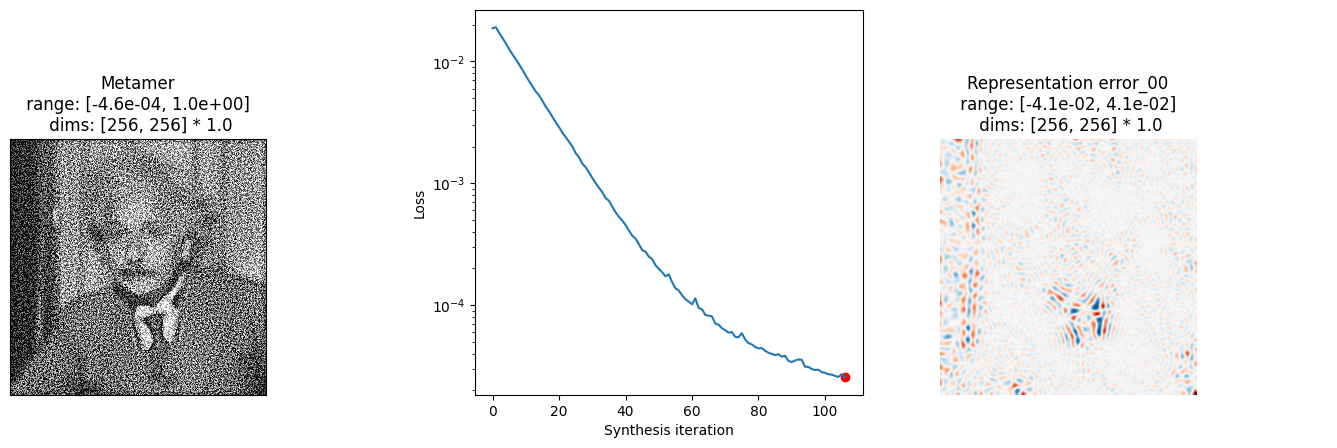

In [54]:
po.synth.metamer.plot_synthesis_status(met);

We can also plot the images and their representation directly:

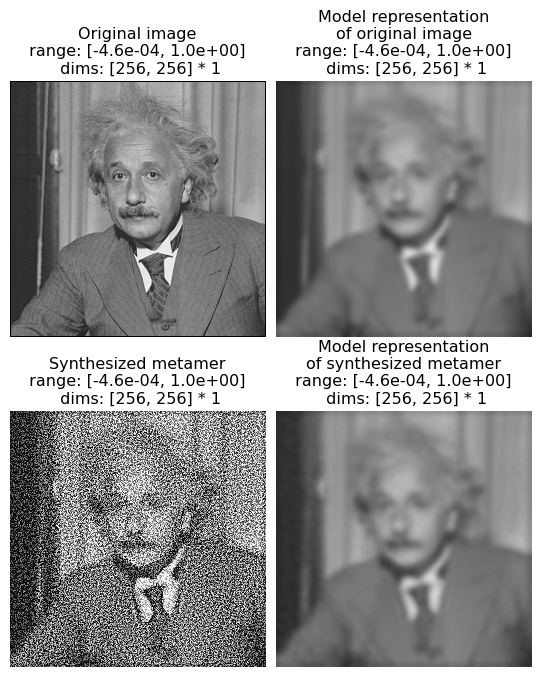

In [55]:
fig = po.imshow([img, model(img), met.metamer, model(met.metamer)], 
                col_wrap=2, vrange='auto1',
                title=['Original image', 'Model representation\nof original image',
                       'Synthesized metamer', 'Model representation\nof synthesized metamer']);

We can also automate that synthesis status plot, to see the metamer being created:

In [56]:
po.synth.metamer.animate(met)

/opt/conda/lib/python3.11/site-packages/plenoptic/synthesize/metamer.py:1653: UserWarning: Looks like representation is image-like, haven't fully thought out how to best handle rescaling color ranges yet!
  warnings.warn("Looks like representation is image-like, haven't fully thought out how"
